In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transform
import torchmetrics
import random
import matplotlib
import matplotlib.pyplot as matplot

from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import DataLoader, Subset, random_split, ConcatDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, Normalize, Compose
from torchmetrics import F1Score, Accuracy
from PIL import Image

from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np

In [3]:
project_name='rock-paper-scissors'

In [4]:
# Data directory
data_dir = './dataset'
print(os.listdir(data_dir))

# Classes
classes = os.listdir(data_dir)
print(classes)

['paper', 'rock', 'scissors']
['paper', 'rock', 'scissors']


In [5]:
stats=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_tfms = transform.Compose([
                         transform.Resize((32,32)), 
                         transform.RandomHorizontalFlip(), 
                         transform.ToTensor(), 
                         transform.Normalize(*stats,inplace=True)])

valid_tfms = transform.Compose([transform.Resize((32,32)),transform.ToTensor(), transform.Normalize(*stats)])

In [6]:
rock_paper_scissors_data = ImageFolder(data_dir, train_tfms)

In [7]:
train_size = int(0.85 * len(rock_paper_scissors_data))
val_size = len(rock_paper_scissors_data) - train_size
train_dataset, val_dataset = random_split(rock_paper_scissors_data, [train_size, val_size])

In [8]:
batch_size = 64
num_of_classes = len(classes)
num_of_classes

3

In [ ]:
# Data loaders
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
# val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)

In [ ]:
print(len(val_dataset))

In [9]:
custom_val_dataset = ImageFolder("./professor-dataset/validation", valid_tfms)
print(len(custom_val_dataset))
complete_val_dataset = ConcatDataset([val_dataset,custom_val_dataset])
print(len(complete_val_dataset))


121
1247


In [ ]:
# Just the custom validation dataloader
custom_validation_dataloader = DataLoader(custom_val_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)

In [10]:
test_dataset = ImageFolder("./professor-dataset/test", valid_tfms)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dataloader = DataLoader(complete_val_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)

In [ ]:
type(val_dataloader)

In [ ]:
# Function to show images
def show_images(dataloader):
    for images, labels in dataloader:
        fig, ax = matplot.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break


In [ ]:
show_images(val_dataloader)

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
# Moving Dataloader on the device('Cuda' if available)
train_dataloader = DeviceDataLoader(train_dataloader, device)
# val_dataloader = DeviceDataLoader(val_dataloader, device)

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        
        if in_channels != out_channels or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = nn.Identity()
            
    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out
        
class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()
        self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(256, 512, stride=2),
            ResidualBlock(512, 512)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [16]:
k = 5
number_of_epochs = 25
learning_rate = 0.001
weight_decay = 1e-4

In [17]:
# F-1 Score
def get_f1score(preds, labels):
    f1_score = F1Score(task="multiclass", num_classes=num_of_classes, average='weighted')
    print(f1_score)
    return f1_score(preds, labels)

In [18]:
# Accuracy
def get_accuracy(preds, labels):
    accuracy = Accuracy(task="multiclass", num_classes=num_of_classes).to(device)
    b = accuracy(preds, labels)
    return b

In [19]:
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [20]:
# Evaluate model
def evaluate(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    return all_preds, all_labels

In [21]:
# K-fold cross-validation
kf = KFold(n_splits=k, shuffle=True)

# Train and validate for each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
    print(f'Fold {fold + 1}/{k}')
    
    # Create subset datasets and dataloaders for this fold
    train_subset = Subset(train_dataset, train_indices)
    kfold_val_subset = Subset(train_dataset, val_indices)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    kfold_val_loader = DataLoader(kfold_val_subset, batch_size=64, shuffle=False)
    # Model
    model = ResNet9()
    model.to(device)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
#   optimizer = optim.Adam(model.parameters(), learning_rate)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    train_losses = []
    train_accuracies = []
    
    val_losses = []
    val_accuracies = []
    
    kfold_val_losses = []
    kfold_val_accuracies = []
    
    # Train and validate for this fold
    for epoch in range(number_of_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        kfold_val_loss = train(model,kfold_val_loader,criterion,optimizer)
        val_loss = train(model,val_dataloader,criterion,optimizer)
        
        train_losses.append(train_loss)
        kfold_val_losses.append(kfold_val_loss)
        val_losses.append(val_loss)
        
        preds, labels = evaluate(model, train_loader)
        train_accuracy = get_accuracy(preds, labels)

        preds, labels = evaluate(model, kfold_val_loader)
        kfold_val_accuracy = get_accuracy(preds, labels)

        preds, labels = evaluate(model, val_dataloader)
        val_accuracy = get_accuracy(preds, labels)

        train_accuracies.append(train_accuracy)
        kfold_val_accuracies.append(kfold_val_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch + 1} - Train loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val loss: {val_loss:.4f} - Val accuracy: {val_accuracy:.4f}')
    
    # Saving the Current Fold Model
    torch.save(model, f'fold{fold}.pth')

Fold 1/5
Epoch 1 - Train loss: 0.8406 - Train Accuracy: 0.7541 - Val loss: 0.5178 - Val accuracy: 0.7362
Epoch 2 - Train loss: 0.3274 - Train Accuracy: 0.7376 - Val loss: 0.3272 - Val accuracy: 0.7065
Epoch 3 - Train loss: 0.2040 - Train Accuracy: 0.9279 - Val loss: 0.1981 - Val accuracy: 0.9150
Epoch 4 - Train loss: 0.1463 - Train Accuracy: 0.9632 - Val loss: 0.1501 - Val accuracy: 0.9358
Epoch 5 - Train loss: 0.1150 - Train Accuracy: 0.9383 - Val loss: 0.1352 - Val accuracy: 0.8893
Epoch 6 - Train loss: 0.0778 - Train Accuracy: 0.9590 - Val loss: 0.1028 - Val accuracy: 0.9399
Epoch 7 - Train loss: 0.0424 - Train Accuracy: 0.9900 - Val loss: 0.0906 - Val accuracy: 0.9647
Epoch 8 - Train loss: 0.0451 - Train Accuracy: 0.9849 - Val loss: 0.0849 - Val accuracy: 0.9559
Epoch 9 - Train loss: 0.0363 - Train Accuracy: 0.9967 - Val loss: 0.0854 - Val accuracy: 0.9703
Epoch 10 - Train loss: 0.0287 - Train Accuracy: 0.9792 - Val loss: 0.0858 - Val accuracy: 0.9407
Epoch 11 - Train loss: 0.0261 

Epoch 11 - Train loss: 0.0253 - Train Accuracy: 0.9965 - Val loss: 0.0644 - Val accuracy: 0.9671
Epoch 12 - Train loss: 0.0168 - Train Accuracy: 0.9990 - Val loss: 0.0531 - Val accuracy: 0.9679
Epoch 13 - Train loss: 0.0161 - Train Accuracy: 0.9931 - Val loss: 0.0456 - Val accuracy: 0.9639
Epoch 14 - Train loss: 0.0127 - Train Accuracy: 0.9994 - Val loss: 0.0296 - Val accuracy: 0.9783
Epoch 15 - Train loss: 0.0074 - Train Accuracy: 0.9998 - Val loss: 0.0200 - Val accuracy: 0.9751
Epoch 16 - Train loss: 0.0079 - Train Accuracy: 1.0000 - Val loss: 0.0106 - Val accuracy: 0.9783
Epoch 17 - Train loss: 0.0055 - Train Accuracy: 1.0000 - Val loss: 0.0065 - Val accuracy: 0.9791
Epoch 18 - Train loss: 0.0028 - Train Accuracy: 1.0000 - Val loss: 0.0036 - Val accuracy: 0.9767
Epoch 19 - Train loss: 0.0017 - Train Accuracy: 1.0000 - Val loss: 0.0026 - Val accuracy: 0.9783
Epoch 20 - Train loss: 0.0011 - Train Accuracy: 1.0000 - Val loss: 0.0025 - Val accuracy: 0.9751
Epoch 21 - Train loss: 0.0013 

In [ ]:
model = torch.load("./model/256/3Fold-100Epochs/fold1.pth")
model.to(device)
train_for_more_epochs(model,100)

In [ ]:
# Saving the model
torch.save(model, './saved_model.pth')

In [22]:
# Function to plot the losses
def plot_losses():
    matplot.plot(train_losses, '-bx')
    matplot.plot(val_losses, '-rx')
    matplot.xlabel('epoch')
    matplot.ylabel('loss')
    matplot.legend(['Training', 'Validation'])
    matplot.title('Loss vs. No. of epochs');

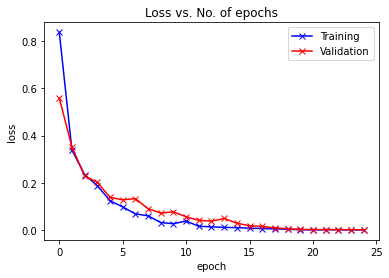

In [23]:
plot_losses()

In [63]:
# Testing the model
test_model = ResNet9()
PATH = './fold1.pth'
test_model = torch.load(PATH)
test_model.to(device)

ResNet9(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [64]:
# Evaluating Test Data
preds = []
labels = []
preds, labels = evaluate(test_model, test_dataloader)

# Accuracy
accuracy = get_accuracy(preds, labels)
accuracy

tensor(0.5759, device='cuda:0')

In [47]:
print(len(preds))
print(preds)
print("----")
print(labels)

158
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2,
        1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 1, 1, 0, 0, 1, 2, 0, 0, 2, 0, 0,
        0, 0, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1,
        0, 0, 2, 1, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2])
----
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [68]:
# F-1 SCORE
f1_score = get_f1score(preds, labels)
f1_score

MulticlassF1Score()


RuntimeError: Encountered different devices in metric calculation (see stacktrace for details). This could be due to the metric class not being on the same device as input. Instead of `metric=MulticlassF1Score(...)` try to do `metric=MulticlassF1Score(...).to(device)` where device corresponds to the device of the input.

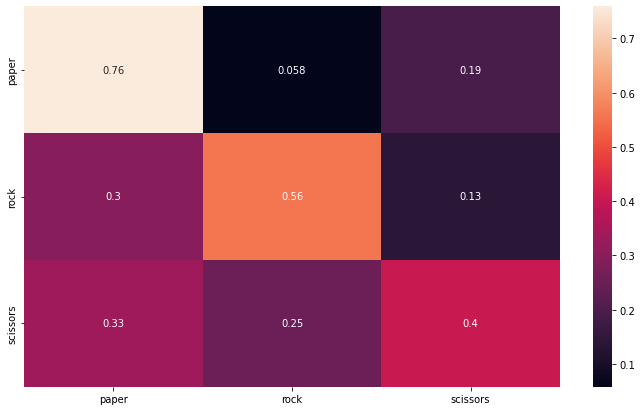

In [66]:
confusion_matrix = np.zeros((num_of_classes, num_of_classes))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = test_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

matplot.figure(figsize=(12,7))

df_cm = pd.DataFrame((confusion_matrix/(np.sum(confusion_matrix, axis=1))), index=classes, columns=classes)
heatmap = sn.heatmap(df_cm, annot=True)